In [63]:
import pandas as pd
import nltk
from collections import Counter


In [64]:
df=pd.read_csv("Data\\commentsCleanData.csv")
df

,videoId,title,videoLikes,videoViews,commenter_name,comments
0,Fj-g-cmSzbo,Beautiful but toxic.,56482,808475,@RohitandKanu,you guys know of any other beautiful but toxic...
1,Fj-g-cmSzbo,Beautiful but toxic.,56482,808475,@rignudignu7200,a porsche
2,Fj-g-cmSzbo,Beautiful but toxic.,56482,808475,@mastmogachi,monkey shoulder is looking very beautiful rig...
3,Fj-g-cmSzbo,Beautiful but toxic.,56482,808475,@DD-pe3no,NaN
4,Fj-g-cmSzbo,Beautiful but toxic.,56482,808475,@MrKamei,my crush
...,...,...,...,...,...,...
6298,xxwNglca0Bo,Limca Book of World Records - Renu Sukheja,1073,149466,@dmcindianfan5374,just went back 10 years ago
6299,xxwNglca0Bo,Limca Book of World Records - Renu Sukheja,1073,149466,@coolbreeze1262,is the record still to her
6300,xxwNglca0Bo,Limca Book of World Records - Renu Sukheja,1073,149466,@Notebook-ur1st,wow she looks different \ni follow them for e...
6301,xxwNglca0Bo,Limca Book of World Records - Renu Sukheja,1073,149466,@Prathikraj_mysorean,one can see rohits journey


In [65]:
df['comments'] = df['comments'].astype(str)
df['comments'] = df['comments'].str.lower()


In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['comments'].fillna(''))

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


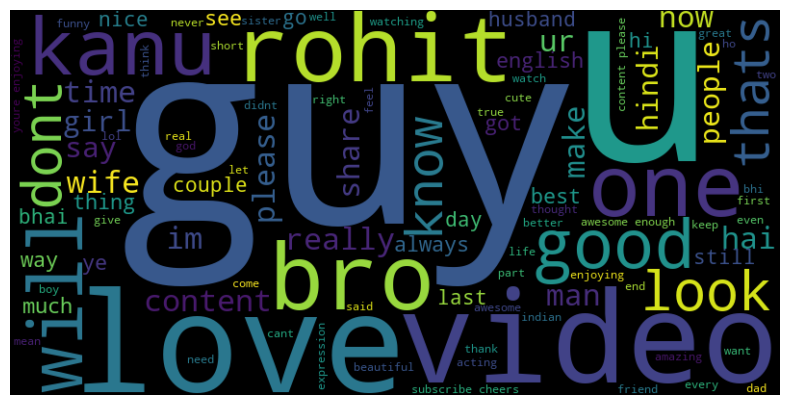

In [67]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(df['comments'].fillna('')))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [68]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display the top words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #1:
thats guys content awesome like cheers share subscribe enjoying youre
Topic #2:
love like couple cute guys videos amazing funny relatable ur
Topic #3:
best good dont beautiful god im acting know come song
Topic #4:
just rohit didnt people understand hindi wife english indian video
Topic #5:
bro nice hai lol bhai kanu thought got real man


In [69]:
from sklearn.preprocessing import LabelEncoder

df['videoId_encoded'] = LabelEncoder().fit_transform(df['videoId'])
df['commenter_encoded'] = LabelEncoder().fit_transform(df['commenter_name'])

interaction_matrix = df.pivot_table(index='commenter_encoded', 
                                    columns='videoId_encoded', 
                                    values='comments', 
                                    aggfunc='count', 
                                    fill_value=0)

interaction_matrix.fillna(0, inplace=True)


In [70]:
from sklearn.decomposition import NMF

# Apply Non-negative Matrix Factorization
nmf = NMF(n_components=5, random_state=42)
user_features = nmf.fit_transform(interaction_matrix)
video_features = nmf.components_

# Recommend videos for a user
user_id = 0  # Example user ID
user_vector = user_features[user_id]
recommendations = user_vector.dot(video_features)
recommended_video_ids = recommendations.argsort()[::-1][:5]  # Top 5 recommendations

print("Recommended video IDs:", recommended_video_ids)


Recommended video IDs: [304 179   3 261 121]


In [71]:
from sklearn.preprocessing import StandardScaler

# Combine TF-IDF features with video metadata (likes, views)
metadata_features = df[['videoLikes', 'videoViews']].fillna(0)
scaler = StandardScaler()
metadata_scaled = scaler.fit_transform(metadata_features)

combined_features = pd.concat([tfidf_df, pd.DataFrame(metadata_scaled)], axis=1)


In [72]:
from sklearn.neighbors import NearestNeighbors


combined_features.columns = combined_features.columns.astype(str)

knn = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn.fit(combined_features.values)  


# Recommend similar videos
video_index = 0  
distances, indices = knn.kneighbors([combined_features.iloc[video_index]])

print("Recommended videos for video index", video_index, ":", indices[0])



Recommended videos for video index 0 : [   0  329   16 3112   57]


In [73]:
# Recommended video indices
recommended_indices = indices[0]

# Extract video titles
recommended_titles = df.iloc[recommended_indices]['title']

# Remove duplicates
recommended_titles = recommended_titles.drop_duplicates()

# Print recommended video titles
print("Recommended video titles:")
for title in recommended_titles:
    print(title)


Recommended video titles:
Beautiful but toxic.
Ex Equation.
Zodiac signs on a date - Part 2 | Rohit & Kanupriya
Good boy VS Bad boy
